# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 25 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 25 апреля, -4 баллов после 06:00 2 мая, -6 баллов после 06:00 9 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,3)

%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [384]:
# %%pycodestyle

class MyKmeans:

    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        if self.metric == 'euclidean':
            self.distance = self.euclidean_m

    @staticmethod
    def euclidean_m(X, Y):
        return np.sqrt(((X - Y) ** 2).sum(axis=1))

    # Евклиидово расстояние между матрицами
    @staticmethod
    def numpy_dist(X, Y):
        x_dist = (X ** 2).sum(axis=1)
        y_dist = (Y ** 2).sum(axis=1)
        xy_dist = X.dot(Y.T)
        dist = - 2 * xy_dist + y_dist + x_dist.reshape(-1, 1)
        return np.sqrt(dist)

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        if self.init == 'random':
            self.centroids = X[np.random.choice(X.shape[0], self.k)]

        elif self.init == 'k-means':
            # Произвольный выбор одной из имеющихся точек в качестве первого центроида.
            self.centroids[0] = X[np.random.choice(len(X), 1)]
            for j in range(1, self.k):
                d_x2 = np.array(np.min(MyKmeans.numpy_dist(X, self.centroids[:j]) ** 2, axis=1))
                # Выбрать из этих точек следующий центроид так, чтобы вероятность выбора точки 
                # была пропорциональна вычисленному для неё квадрату расстояния. 
                Sum = np.sum(d_x2) * np.random.rand()
                Sum2 = 0
                for i in range(len(X)):
                    Sum2 += d_x2[i]
                    if Sum2 > Sum:
                        self.centroids[j] = X[i]
                        break
        eps = 1e-10
        for it in range(self.max_iter):
            old_centroids = copy(self.centroids)

            dist = np.empty((self.k, X.shape[0]))
            for i in range(self.k):
                dist[i, :] = self.distance(X, self.centroids[i, :])

            self.labels = np.argmin(dist, axis=0)
            control_dist = 0

            for i in range(self.k):
                # Пересчёт центроидов.
                self.centroids[i] = np.mean(X[self.labels == i], axis=0)
                control_dist += np.linalg.norm(old_centroids[i] - self.centroids[i])
            # отслеживание сходимости    
            if control_dist < eps:
                return self

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        dist = np.empty((self.k, X.shape[0]))
        for i in range(self.k):
            dist[i, :] = self.distance(X, self.centroids[i, :])
        self.labels = np.argmin(dist, axis=0)
        return self.labels


class MiniBatchKMeans(MyKmeans):
    def __init__(self, k=3, metric='euclidean', max_iter=1000, random_state=None, init='random', batch_size=10):

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.batch_size = batch_size
        if self.metric == 'euclidean':
            self.distance = self.euclidean_m

    @staticmethod
    def euclidean_m(X, Y):
        if len(X.shape) == 1:
            return np.linalg.norm(X - Y)
        return np.sqrt(((X - Y) ** 2).sum(axis=1))

    def fit(self, X, y=None):

        # Инициализация генератора случайных чисел.
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X.
        self.labels = np.empty(X.shape[0])

        # Массив с центроидами кластеров.
        self.centroids = np.empty((self.k, X.shape[1]))

        if self.init == 'random':
            self.centroids = X[np.random.choice(X.shape[0], self.k)]

        elif self.init == 'k-means':
            # Произвольный выбор одной из имеющихся точек в качестве первого центроида.
            self.centroids[0] = X[np.random.choice(len(X), 1)]
            for j in range(1, self.k):
                d_x2 = np.array(np.min(cdist(X, self.centroids[:j]) ** 2, axis=1))
                # Выбрать из этих точек следующий центроид так, чтобы вероятность выбора точки 
                # была пропорциональна вычисленному для неё квадрату расстояния. 
                Sum = np.sum(d_x2) * np.random.rand()
                Sum2 = 0
                for i in range(len(X)):
                    Sum2 += d_x2[i]
                    if Sum2 > Sum:
                        self.centroids[j] = X[i]
                        break

        # Для прекращения итерирования в случае сходимости.
        eps = 1e-10
        v = np.zeros(self.k)

        dist = np.zeros((self.k, X.shape[0]))
        for it in range(self.max_iter):
            control = 0
            old_centroids = copy(self.centroids)
            batch = X[np.random.choice(np.arange(X.shape[0]), self.batch_size)]
            dist = np.empty((self.k, batch.shape[0]))

            for i in range(self.k):
                dist[i, :] = self.distance(batch, self.centroids[i, :])

            self.labels = np.argmin(dist, axis=0)
            cluster_points = [[]] * self.k
            for j in range(len(batch)):
                i = self.labels[j]
                cluster_points[i].append(batch[j])

                n = 1 / len(cluster_points[i])
                self.centroids[i] = (1 - n) * self.centroids[i] + n * batch[j]

            for j in range(self.k):
                control += np.linalg.norm(old_centroids[j] - self.centroids[j])

            # отслеживание сходимости
            if control < eps:
                return self

        return self


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [316]:
import time
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

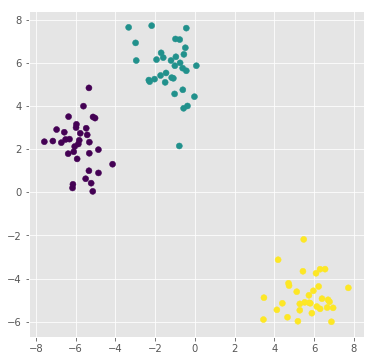

In [319]:
plt.figure(figsize=(6, 6)); 
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

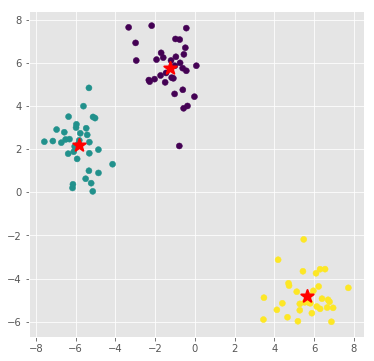

In [385]:
## Работоспособность MyKmeans
model = MyKmeans(k=3, init='random')
model.fit(X)
plt.figure(figsize=(6, 6));            
Cen = np.array(model.centroids)
plt.scatter(X[:, 0], X[:, 1], c = model.predict(X))
plt.scatter(Cen[:, 0], Cen[:, 1], marker='*', s=169, linewidths=2, color='r', zorder=5)
        

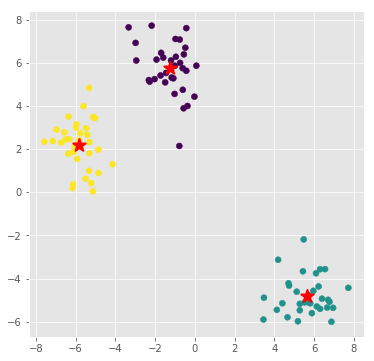

In [386]:
## Работоспособность MyKmeans++
model = MyKmeans(k=3, init='k-means')
model.fit(X)
plt.figure(figsize=(6, 6));            
Cen = np.array(model.centroids)
plt.scatter(X[:, 0], X[:, 1], c = model.predict(X))
plt.scatter(Cen[:, 0], Cen[:, 1], marker='*', s=169, linewidths=2, color='r', zorder=5)

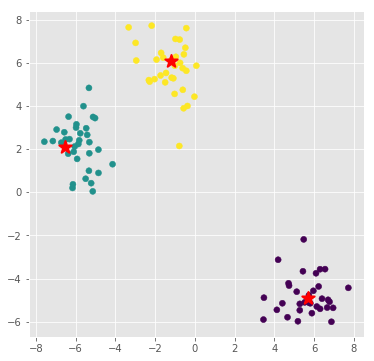

In [388]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
model = MiniBatchKMeans(k=3, init='random')
model.fit(X)
plt.figure(figsize=(6, 6));            
Cen = np.array(model.centroids)
plt.scatter(X[:, 0], X[:, 1], c = model.predict(X))
plt.scatter(Cen[:, 0], Cen[:, 1], marker='*', s=169, linewidths=2, color='r', zorder=5)

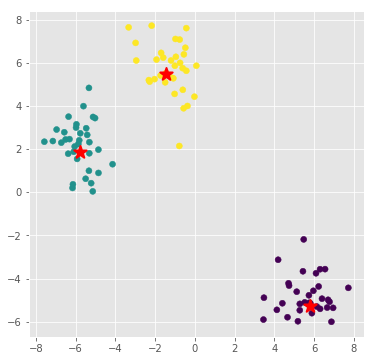

In [391]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
model = MiniBatchKMeans(k=3, init='k-means')
model.fit(X)
plt.figure(figsize=(6, 6));            
Cen = np.array(model.centroids)
plt.scatter(X[:, 0], X[:, 1], c = model.predict(X))
plt.scatter(Cen[:, 0], Cen[:, 1], marker='*', s=169, linewidths=2, color='r', zorder=5)

12.9 ms ± 321 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.4 ms ± 407 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
19.1 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
37.8 ms ± 4.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
81.7 ms ± 5.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
175 ms ± 6.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


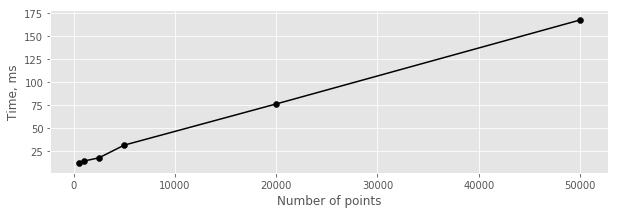

In [182]:
## Время выполнения алгоритма Kmeans из sklearn
numList = [500, 1000, 2500, 5000, 20000 ,  50000]
timeList = []

for n in numList:
    Points, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
                       center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model = KMeans(n_clusters=3)
    result = %%timeit -n 10 -o model.fit(Points)
    timeList.append(result.best * 1000)

plt.plot(numList, timeList, c='k')
plt.scatter(numList, timeList, c='k')
plt.xlabel('Number of points')
plt.ylabel('Time, ms')
plt.show()

The slowest run took 27.01 times longer than the fastest. This could mean that an intermediate result is being cached.
6.74 ms ± 8.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.86 ms ± 702 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.46 ms ± 825 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.56 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.2 ms ± 5.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
124 ms ± 22.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


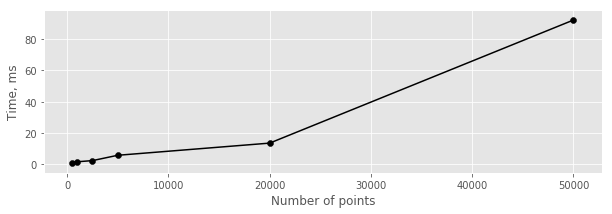

In [191]:
## Время выполнения алгоритма MyKmeans
timeList = []

for n in numList:
    Points, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
                       center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model = MyKmeans(k=3,init='random')
    result = %%timeit -n 10 -o model.fit(Points)
    timeList.append(result.best * 1000)

plt.plot(numList, timeList, c='k')
plt.scatter(numList, timeList, c='k')
plt.xlabel('Number of points')
plt.ylabel('Time, ms')
plt.show()
# здесь в зависимости от рандомного раскидывания центроид 
# в некоторых случаях алгоритм работает в 10-20 раз медленнее
# но в среднем выдает нормальную скорость
# в kmeans++ такого не замечается 

1.2 ms ± 191 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.71 ms ± 475 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.91 ms ± 291 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.3 ms ± 2.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.5 ms ± 4.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
105 ms ± 38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


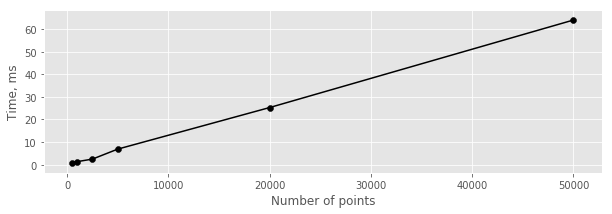

In [186]:
## Время выполнения алгоритма MyKmeans++
timeList = []

for n in numList:
    Points, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
                       center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model = MyKmeans(k=3,init='k-means')
    result = %%timeit -n 10 -o model.fit(Points)
    timeList.append(result.best * 1000)

plt.plot(numList, timeList, c='k')
plt.scatter(numList, timeList, c='k')
plt.xlabel('Number of points')
plt.ylabel('Time, ms')
plt.show()

137 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
137 ms ± 689 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
140 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
143 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
173 ms ± 6.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
194 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


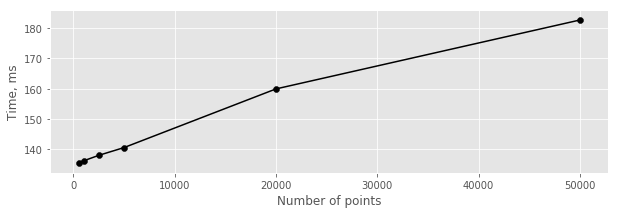

In [382]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
timeList = []
for n in numList:
    Points, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
                       center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model = MiniBatchKMeans(k=3, init='random')
    result = %%timeit -n 10 -o model.fit(Points)
    timeList.append(result.best * 1000)

plt.plot(numList, timeList, c='k')
plt.scatter(numList, timeList, c='k')
plt.xlabel('Number of points')
plt.ylabel('Time, ms')
plt.show()

139 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
145 ms ± 4.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
153 ms ± 7.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
154 ms ± 8.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
176 ms ± 9.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
212 ms ± 9.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


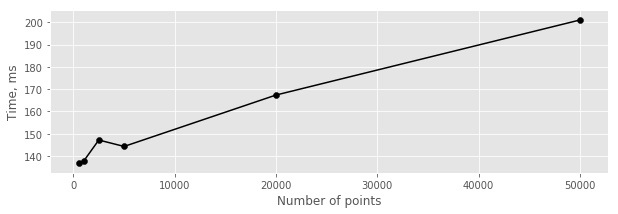

In [383]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
timeList = []
for n in numList:
    Points, y = make_blobs(n_samples=n, n_features=2, centers=3, cluster_std=1, 
                       center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    model = MiniBatchKMeans(k=3, init='k-means')
    result = %%timeit -n 10 -o model.fit(Points)
    timeList.append(result.best * 1000)

plt.plot(numList, timeList, c='k')
plt.scatter(numList, timeList, c='k')
plt.xlabel('Number of points')
plt.ylabel('Time, ms')
plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [332]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [392]:
df_sns = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis = 1);

for i in df_sns.columns:
    df_sns[i] = (df_sns[i] - df_sns[i].mean()) / df_sns[i].std()

In [404]:
X = df_sns.values
words = df_sns.columns

In [450]:
%%time
## MyKMeans
model = MyKmeans(k = 9)
model.fit(X)
for i, c in enumerate(model.centroids):
    print(words[np.argsort(c)[-5:]], labels[labels == i].size)

Index(['dress', 'dance', 'mall', 'cute', 'shopping'], dtype='object') 303
Index(['death', 'hair', 'die', 'drugs', 'drunk'], dtype='object') 1337
Index(['shopping', 'sports', 'volleyball', 'basketball', 'softball'], dtype='object') 26683
Index(['bible', 'soccer', 'jesus', 'tennis', 'blonde'], dtype='object') 388
Index(['swimming', 'rock', 'music', 'band', 'marching'], dtype='object') 49
Index(['rock', 'sports', 'basketball', 'football', 'baseball'], dtype='object') 170
Index(['rock', 'drugs', 'hair', 'sex', 'kissed'], dtype='object') 368
Index(['clothes', 'mall', 'shopping', 'abercrombie', 'hollister'], dtype='object') 692
Index(['death', 'church', 'god', 'jesus', 'bible'], dtype='object') 10
CPU times: user 3.28 s, sys: 0 ns, total: 3.28 s
Wall time: 3.28 s


In [451]:
%%time
## MyKMeans++
model = MyKmeans(k = 9, init='k-means')
model.fit(X)
for i, c in enumerate(model.centroids):
    print(words[np.argsort(c)[-5:]], labels[labels == i].size)

Index(['shopping', 'music', 'god', 'jesus', 'church'], dtype='object') 303
Index(['drunk', 'sex', 'hair', 'drugs', 'kissed'], dtype='object') 1337
Index(['shopping', 'sports', 'basketball', 'volleyball', 'softball'], dtype='object') 26683
Index(['soccer', 'sports', 'basketball', 'baseball', 'football'], dtype='object') 388
Index(['drunk', 'death', 'soccer', 'tennis', 'blonde'], dtype='object') 49
Index(['dress', 'dance', 'mall', 'cute', 'shopping'], dtype='object') 170
Index(['clothes', 'mall', 'shopping', 'abercrombie', 'hollister'], dtype='object') 368
Index(['swimming', 'rock', 'music', 'band', 'marching'], dtype='object') 692
Index(['music', 'church', 'jesus', 'god', 'bible'], dtype='object') 10
CPU times: user 3.63 s, sys: 221 ms, total: 3.85 s
Wall time: 3.61 s


In [446]:
%%time
## MyKMeans с MiniBatchMyKMeans
model = MiniBatchKMeans(k = 9, init='random',batch_size=300)
model.fit(X)
labels=model.predict(X)
for i, c in enumerate(model.centroids):
    print(words[np.argsort(c)[-5:]], labels[labels == i].size)

Index(['rock', 'swimming', 'music', 'marching', 'band'], dtype='object') 303
Index(['sex', 'clothes', 'drugs', 'kissed', 'hair'], dtype='object') 1337
Index(['swimming', 'sports', 'sexy', 'hot', 'death'], dtype='object') 26683
Index(['church', 'death', 'god', 'jesus', 'softball'], dtype='object') 388
Index(['kissed', 'rock', 'clothes', 'death', 'die'], dtype='object') 49
Index(['cute', 'football', 'jesus', 'kissed', 'baseball'], dtype='object') 170
Index(['clothes', 'shopping', 'mall', 'abercrombie', 'hollister'], dtype='object') 368
Index(['cute', 'rock', 'hollister', 'shopping', 'cheerleading'], dtype='object') 692
Index(['death', 'mall', 'baseball', 'football', 'sexy'], dtype='object') 10
CPU times: user 2.39 s, sys: 230 µs, total: 2.39 s
Wall time: 2.38 s


In [445]:
%%time
## MyKMeans++ с MiniBatchMyKMeans
model = MiniBatchKMeans(k = 9, init='k-means',batch_size=300)
model.fit(X)
labels=model.predict(X)
for i, c in enumerate(model.centroids):
    print(words[np.argsort(c)[-5:]], labels[labels == i].size)

Index(['jesus', 'softball', 'sports', 'church', 'tennis'], dtype='object') 482
Index(['dress', 'cute', 'swimming', 'sexy', 'basketball'], dtype='object') 28712
Index(['music', 'hollister', 'hair', 'abercrombie', 'clothes'], dtype='object') 60
Index(['drunk', 'sex', 'drugs', 'die', 'music'], dtype='object') 212
Index(['rock', 'cute', 'music', 'band', 'marching'], dtype='object') 427
Index(['kissed', 'softball', 'blonde', 'hair', 'sex'], dtype='object') 8
Index(['sex', 'drugs', 'hair', 'kissed', 'sports'], dtype='object') 14
Index(['hot', 'church', 'god', 'jesus', 'bible'], dtype='object') 39
Index(['death', 'die', 'hair', 'drunk', 'drugs'], dtype='object') 46
CPU times: user 2.55 s, sys: 7.91 ms, total: 2.56 s
Wall time: 2.56 s


## Вывод

Проведя много испытаний над различными типами данных(синтетические и реальные), Я бы не стал выделять какой-то из этих алгоритмов, как наилучший, ибо каждый из них имеет свои недостатки и преимущества либо в скорости либо в стабильности.

Алгоритм KMeans требует больше операций, но стабильнее MiniBatchKMeans, но при некоторых начальных положениях центроидов он может сходится неправильно. Этой проблемы нет в KMeans++, который более трудоемкий. Алгоритм MiniBatchKMeans с KMeans требует меньше времени, но менее стабилен при большом количестве кластеров или при наличии маленьких кластеров. Алгоритм MiniBatchKMeans c KMeans++ работает стабильнее. 

при этом каждый алгоритм на реальных данных более менее выделил как самый частый кластер людей, которые причастны к спорту.